In [1]:
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score,cohen_kappa_score,balanced_accuracy_score,median_absolute_error

%load_ext sql
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'



In [219]:
def gather_data(standard_type,maxMatch=True,includeAssayType=True,
                minOverlap=5,minAssaySize=20,maxAssaySize=100,
                includeActivityCuration=True,onlyDocs=True,removeMutants=True,noDuplicateDocs=True):
    # password is stored in ~/.pgpass, so we don't need to worry about it here
    connection_string = f"postgresql://ccg_read@scotland/chembl_32"

    %config SqlMagic.feedback = False

    %sql $connection_string \
        drop table if exists temp_assays

    if standard_type in ('Ki','IC50'):
        %sql \
        select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
                  count(distinct(molregno)) cnt,pref_name,assays.doc_id doc_id,docs.year doc_date \
                into temporary table temp_assays  \
                from activities  \
                join assays using(assay_id)  \
                join docs on (assays.doc_id = docs.doc_id)  \
                join target_dictionary as targets using (tid) \
                where pchembl_value is not null   \
                and standard_type=:standard_type \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
                and target_type = 'SINGLE PROTEIN' \
                group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                          assays.doc_id,docs.year) \
                order by cnt desc; 
    else:
        %sql \
        select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
                  count(distinct(molregno)) cnt,pref_name,assays.doc_id doc_id,docs.year doc_date \
                into temporary table temp_assays  \
                from activities  \
                join assays using(assay_id)  \
                join docs on (assays.doc_id = docs.doc_id)  \
                join target_dictionary as targets using (tid) \
                where pchembl_value is not null   \
                and standard_type in ('IC50','AC50','pIC50','XC50','EC50') \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
                and target_type = 'SINGLE PROTEIN' \
                group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                          assays.doc_id,docs.year) \
                order by cnt desc; 
                  
    if onlyDocs:
        %sql \
        delete from temp_assays where doc_date is null;

    if removeMutants:
        %sql \
        delete from temp_assays where lower(description) like '%mutant%' or lower(description) like '%recombinant%';       

    print('goldilocks')
    %sql \
        drop table if exists goldilocks
    %sql \
    select assay_id,tid,molregno,pchembl_value,temp_assays.doc_id,standard_type,activity_id into temporary table goldilocks \
    from activities \
    join temp_assays using (assay_id) \
    where pchembl_value is not null   \
    and standard_units = 'nM'  \
    and data_validity_comment is null  \
    and standard_relation = '=' \
    and cnt>=:minAssaySize and cnt<=:maxAssaySize;

    if standard_type in ('Ki','IC50'):
        %sql \
        delete from goldilocks where standard_type != :standard_type;
    else:
        %sql \
        delete from goldilocks where standard_type not in ('IC50','AC50','pIC50','XC50','EC50');
            
            
    print('goldilocks_ovl')
    %sql \
        drop table if exists goldilocks_ovl
    if includeActivityCuration:
        %sql \
        select c1.tid,c1.assay_id aid1,c2.assay_id aid2,count(distinct c1.molregno) ovl,\
           c1.doc_id doc_id1, c2.doc_id doc_id2 \
        into temporary table goldilocks_ovl \
        from goldilocks c1 cross join goldilocks c2 \
        where c1.assay_id>c2.assay_id and c1.tid=c2.tid  and c1.molregno=c2.molregno \
        and c1.pchembl_value != c2.pchembl_value \
        and abs(c1.pchembl_value - c2.pchembl_value)!=3.0 \
        group by (c1.tid,c1.assay_id,c2.assay_id,c1.doc_id,c2.doc_id) order by ovl desc;
    else:
        %sql \
        select c1.tid,c1.assay_id aid1,c2.assay_id aid2,count(distinct c1.molregno) ovl, \
           c1.doc_id doc_id1, c2.doc_id doc_id2 \
        into temporary table goldilocks_ovl \
        from goldilocks c1 cross join goldilocks c2 \
        where c1.assay_id>c2.assay_id and c1.tid=c2.tid  and c1.molregno=c2.molregno \
        group by (c1.tid,c1.assay_id,c2.assay_id,c1.doc_id,c2.doc_id) order by ovl desc;

    if noDuplicateDocs:
        %sql \
        delete from goldilocks_ovl where doc_id1=doc_id2;


    print('goldilocks_ovl2')
    %sql \
        drop table if exists goldilocks_ovl2
    %sql \
    select ovl.*,count(distinct a1.molregno) a1cnt,count(distinct a2.molregno) a2cnt \
    into temporary table goldilocks_ovl2 \
    from goldilocks_ovl ovl \
      join goldilocks a1 on (aid1=a1.assay_id) join goldilocks a2 on (aid2=a2.assay_id)  \
    where ovl>:minOverlap \
        group by (ovl.tid,ovl.aid1,ovl.aid2,ovl.ovl,ovl.doc_id1,ovl.doc_id2);

    print('goldilocks_ovl3')
    %sql \
        drop table if exists goldilocks_ovl3
    %sql \
    select lu3.chembl_id target_chembl_id,lu1.chembl_id assay1_chembl_id,lu2.chembl_id assay2_chembl_id,ovl,a1cnt,a2cnt,aid1,aid2 \
    into temporary table goldilocks_ovl3 \
    from goldilocks_ovl2 \
    join chembl_id_lookup lu1 on (aid1=lu1.entity_id and lu1.entity_type='ASSAY') \
    join chembl_id_lookup lu2 on (aid2=lu2.entity_id and lu2.entity_type='ASSAY') \
    join chembl_id_lookup lu3 on (tid=lu3.entity_id and lu3.entity_type='TARGET');

    print('get assays')
    if maxMatch:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        where a1.assay_type = a2.assay_type \
        and a1.assay_organism is not distinct from a2.assay_organism \
        and a1.assay_category is not distinct from a2.assay_category \
        and a1.assay_tax_id is not distinct from a2.assay_tax_id \
        and a1.assay_strain is not distinct from a2.assay_strain \
        and a1.assay_tissue is not distinct from a2.assay_tissue \
        and a1.assay_cell_type is not distinct from a2.assay_cell_type \
        and a1.assay_subcellular_fraction is not distinct from a2.assay_subcellular_fraction \
        and a1.bao_format is not distinct from a2.bao_format \
        order by ovl desc;
    elif includeAssayType:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        where a1.assay_type = a2.assay_type \
        order by ovl desc;
    else:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        order by ovl desc;

    print(f'retrieving data for {len(d)} assay pairs')
    pts = []
    for row in d:
        aid1 = row[6]
        aid2 = row[7]
        ad = %sql \
        select a1.molregno,a1.pchembl_value a1_pchembl,a2.pchembl_value a2_pchembl from \
        (select * from goldilocks \
            where assay_id=:aid1 \
        ) a1 \
        join (select * from goldilocks \
            where assay_id=:aid2 \
        ) a2 \
        using (molregno) \
        where a1.standard_type = a2.standard_type;
            
        for row in ad:
            r = list(row)
            r.extend([aid1,aid2])
            pts.append(r)
    return pts

def show_comparison(pts,titl):
    plt.figure(figsize=(12, 12))
    xp = np.array([x[1] for x in pts])
    yp = np.array([x[2] for x in pts])

    plt.subplot(2, 2, 1)
    plt.scatter(xp, yp, alpha=0.2, edgecolors='none')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')
    plt.title(titl)

    plt.subplot(2, 2, 2)
    plt.hexbin(xp, yp, cmap='Blues', bins='log')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')

    plt.subplot(2, 2, 3)
    delts = np.abs(xp - yp)
    plt.hist(delts, bins=20)
    plt.xlabel('delta pchembl')

    plt.tight_layout()

    r, p = stats.spearmanr(xp, yp)
    r2 = r2_score(xp, yp)
    print(
        f'R2={r2:.2f}, Spearman R={r:.2f} MAE={median_absolute_error(xp,yp):.2f}')

    npts = len(delts)
    frac1 = sum(delts > 0.3) / npts
    frac2 = sum(delts > 1) / npts
    print(
        f'{npts} points. Fraction > 0.3: {frac1:.2f}, fraction > 1.0: {frac2:.2f}')

    bins = [5, 6, 7, 8, 9]
    print(f'Fraction with different classifications:')
    for b in bins:
        x_class = xp > b
        y_class = yp > b
        confusion = [[sum(x_class & y_class),
                      sum(x_class & ~y_class)],
                     [sum(~x_class & y_class),
                      sum(~x_class & ~y_class)]]
        missed = sum((xp - b) * (yp - b) < 0) / npts
        print(
            f'\t bin={b}: {missed:.2f}, kappa={cohen_kappa_score(x_class,y_class):.2f}, balanced={balanced_accuracy_score(x_class,y_class):.2f}'
        )
        print(f'\t {confusion}')    

In [220]:
pts = {}

## Max curation

In [221]:
tag = 'xC50, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('xC50')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 32 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

R2=0.66, Spearman R=0.87 MAE=0.09
609 points. Fraction > 0.3: 0.36, fraction > 1.0: 0.13
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.68, balanced=0.85
	 [[577, 8], [7, 17]]
	 bin=6: 0.07, kappa=0.80, balanced=0.91
	 [[448, 27], [16, 118]]
	 bin=7: 0.08, kappa=0.82, balanced=0.91
	 [[242, 29], [25, 313]]
	 bin=8: 0.11, kappa=0.60, balanced=0.81
	 [[77, 32], [41, 459]]
	 bin=9: 0.04, kappa=0.62, balanced=0.84
	 [[24, 10], [17, 558]]


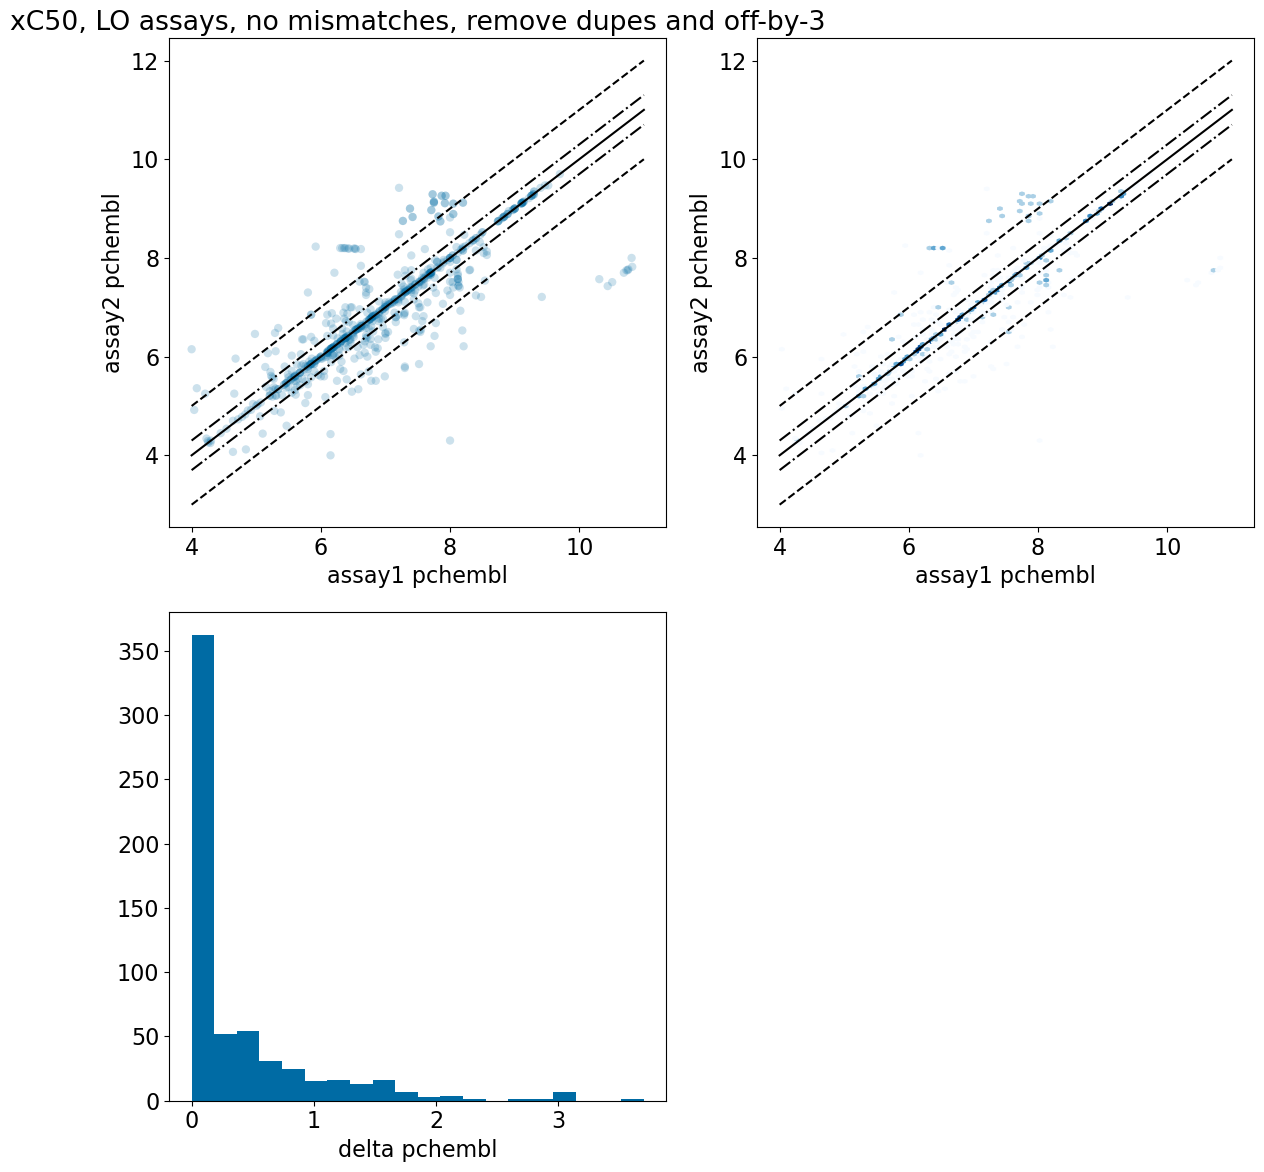

In [222]:
show_comparison(pts[tag],tag)

In [223]:
tag = 'IC50, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('IC50')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 28 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

R2=0.64, Spearman R=0.86 MAE=0.10
535 points. Fraction > 0.3: 0.38, fraction > 1.0: 0.15
Fraction with different classifications:
	 bin=5: 0.03, kappa=0.65, balanced=0.83
	 [[505, 8], [7, 15]]
	 bin=6: 0.07, kappa=0.79, balanced=0.91
	 [[390, 26], [15, 104]]
	 bin=7: 0.08, kappa=0.82, balanced=0.91
	 [[216, 23], [24, 272]]
	 bin=8: 0.12, kappa=0.59, balanced=0.81
	 [[69, 28], [40, 398]]
	 bin=9: 0.05, kappa=0.61, balanced=0.84
	 [[24, 10], [17, 484]]


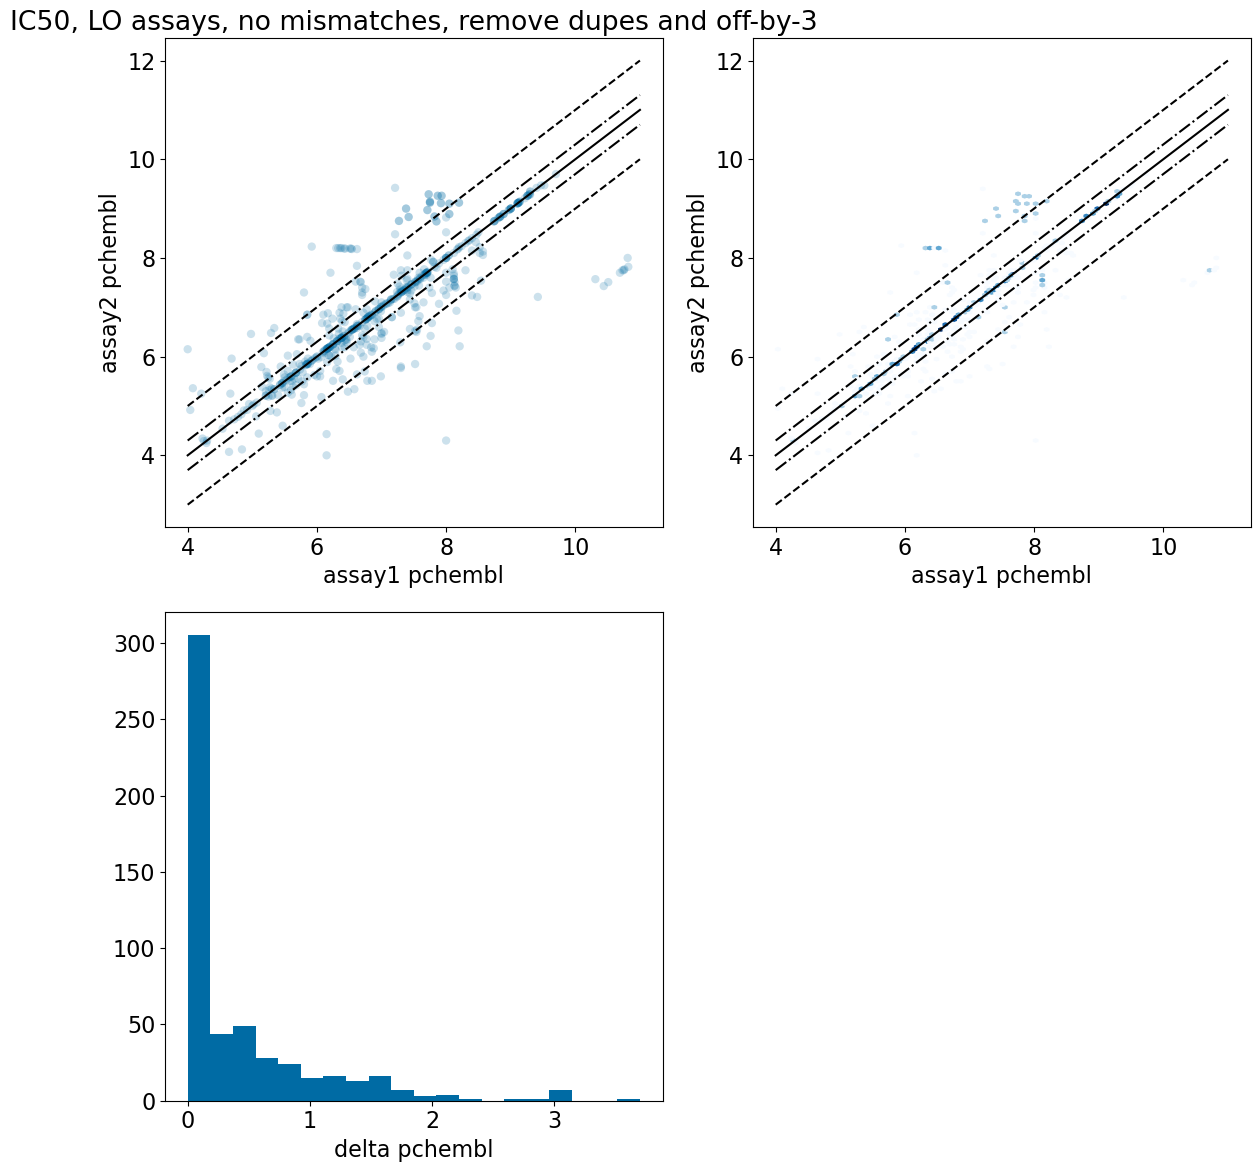

In [224]:
show_comparison(pts[tag],tag)

In [225]:
tag = 'Ki, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('Ki')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 64 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

R2=0.63, Spearman R=0.81 MAE=0.00
1793 points. Fraction > 0.3: 0.26, fraction > 1.0: 0.12
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.72, balanced=0.85
	 [[1530, 46], [59, 158]]
	 bin=6: 0.07, kappa=0.80, balanced=0.90
	 [[1312, 62], [66, 353]]
	 bin=7: 0.13, kappa=0.74, balanced=0.87
	 [[858, 111], [119, 705]]
	 bin=8: 0.07, kappa=0.67, balanced=0.87
	 [[168, 44], [89, 1492]]
	 bin=9: 0.01, kappa=0.49, balanced=0.82
	 [[11, 6], [16, 1760]]


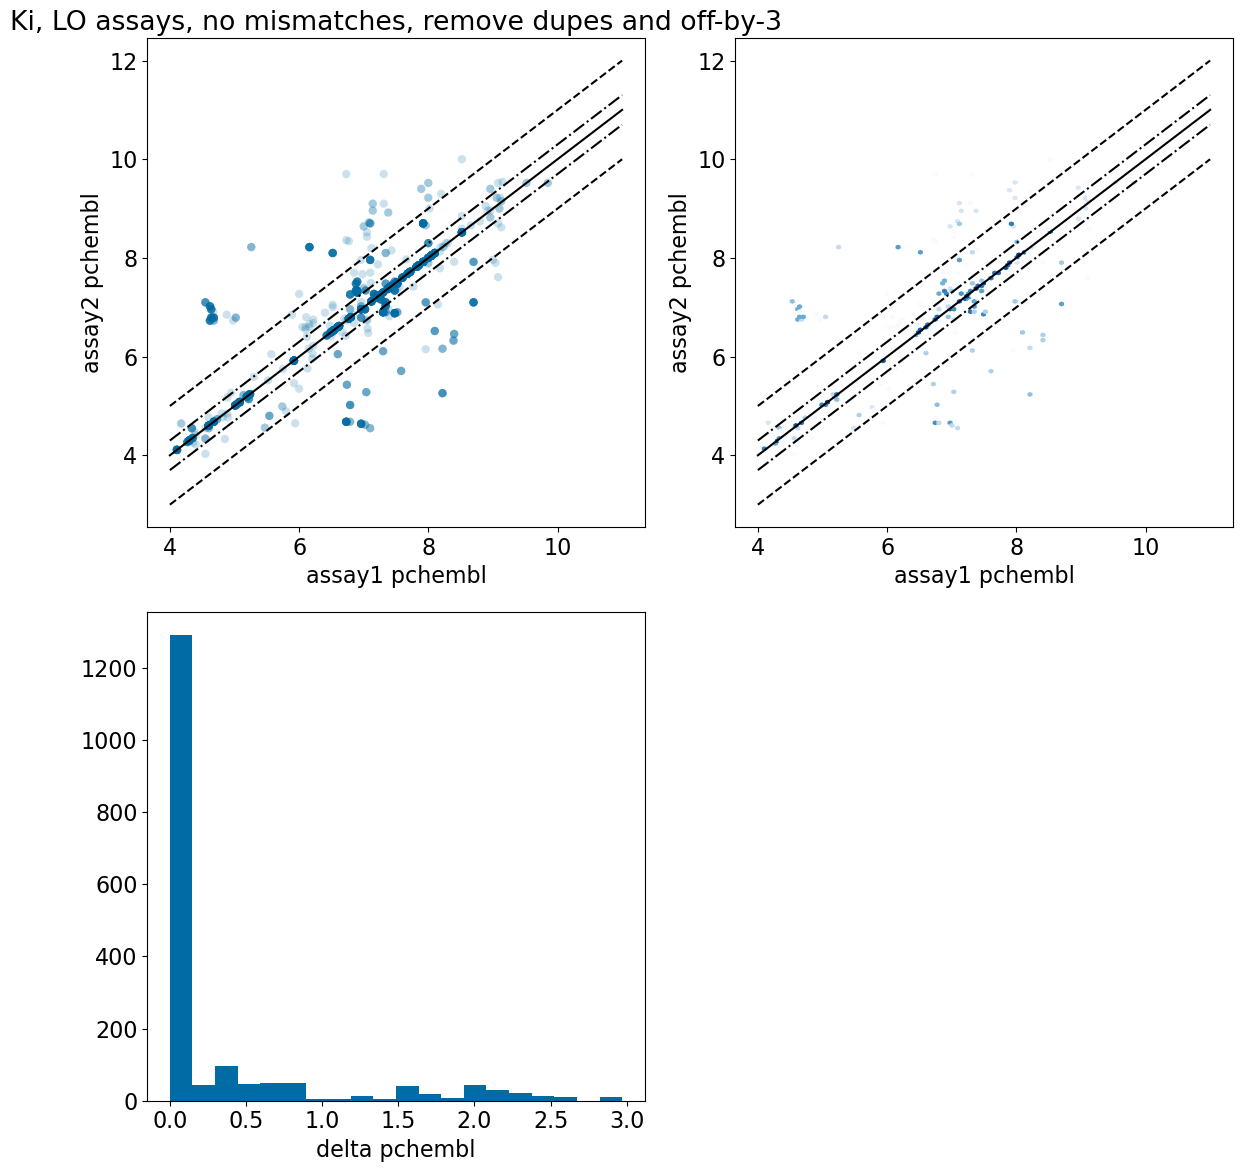

In [226]:
show_comparison(pts[tag],tag)

## Allow doc duplicates

In [227]:
tag = 'xC50, LO assays, no mismatches, remove dupes and off-by-3, dupe docs'
pts[tag] = gather_data('xC50',noDuplicateDocs=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 353 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

R2=0.49, Spearman R=0.77 MAE=0.41
10049 points. Fraction > 0.3: 0.60, fraction > 1.0: 0.21
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.62, balanced=0.81
	 [[8648, 344], [361, 696]]
	 bin=6: 0.14, kappa=0.67, balanced=0.83
	 [[6142, 694], [757, 2456]]
	 bin=7: 0.18, kappa=0.62, balanced=0.82
	 [[3170, 739], [1101, 5039]]
	 bin=8: 0.14, kappa=0.50, balanced=0.78
	 [[1046, 522], [937, 7544]]
	 bin=9: 0.05, kappa=0.28, balanced=0.70
	 [[115, 145], [380, 9409]]


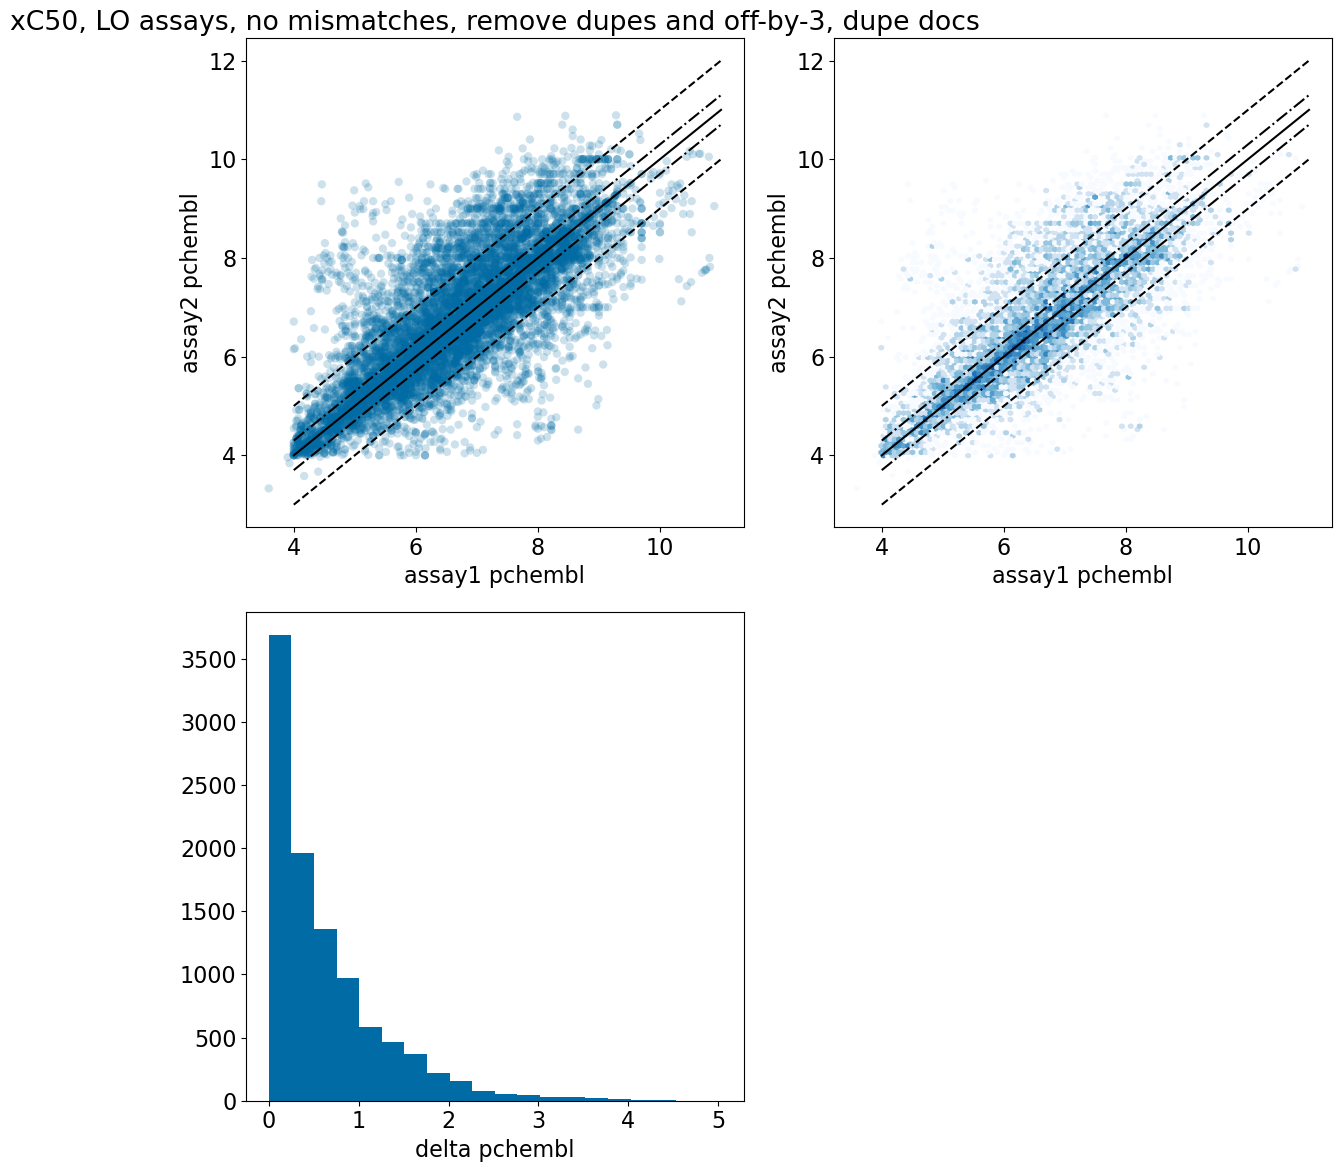

In [228]:
show_comparison(pts[tag],tag)

In [229]:
tag = 'IC50, LO assays, no mismatches, remove dupes and off-by-3, dupe docs'
pts[tag] = gather_data('IC50',noDuplicateDocs=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 276 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

R2=0.47, Spearman R=0.77 MAE=0.40
8605 points. Fraction > 0.3: 0.59, fraction > 1.0: 0.21
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.64, balanced=0.81
	 [[7344, 274], [341, 646]]
	 bin=6: 0.15, kappa=0.65, balanced=0.83
	 [[5123, 614], [696, 2172]]
	 bin=7: 0.18, kappa=0.61, balanced=0.81
	 [[2551, 639], [939, 4476]]
	 bin=8: 0.13, kappa=0.50, balanced=0.78
	 [[835, 439], [765, 6566]]
	 bin=9: 0.05, kappa=0.22, balanced=0.67
	 [[71, 120], [324, 8090]]


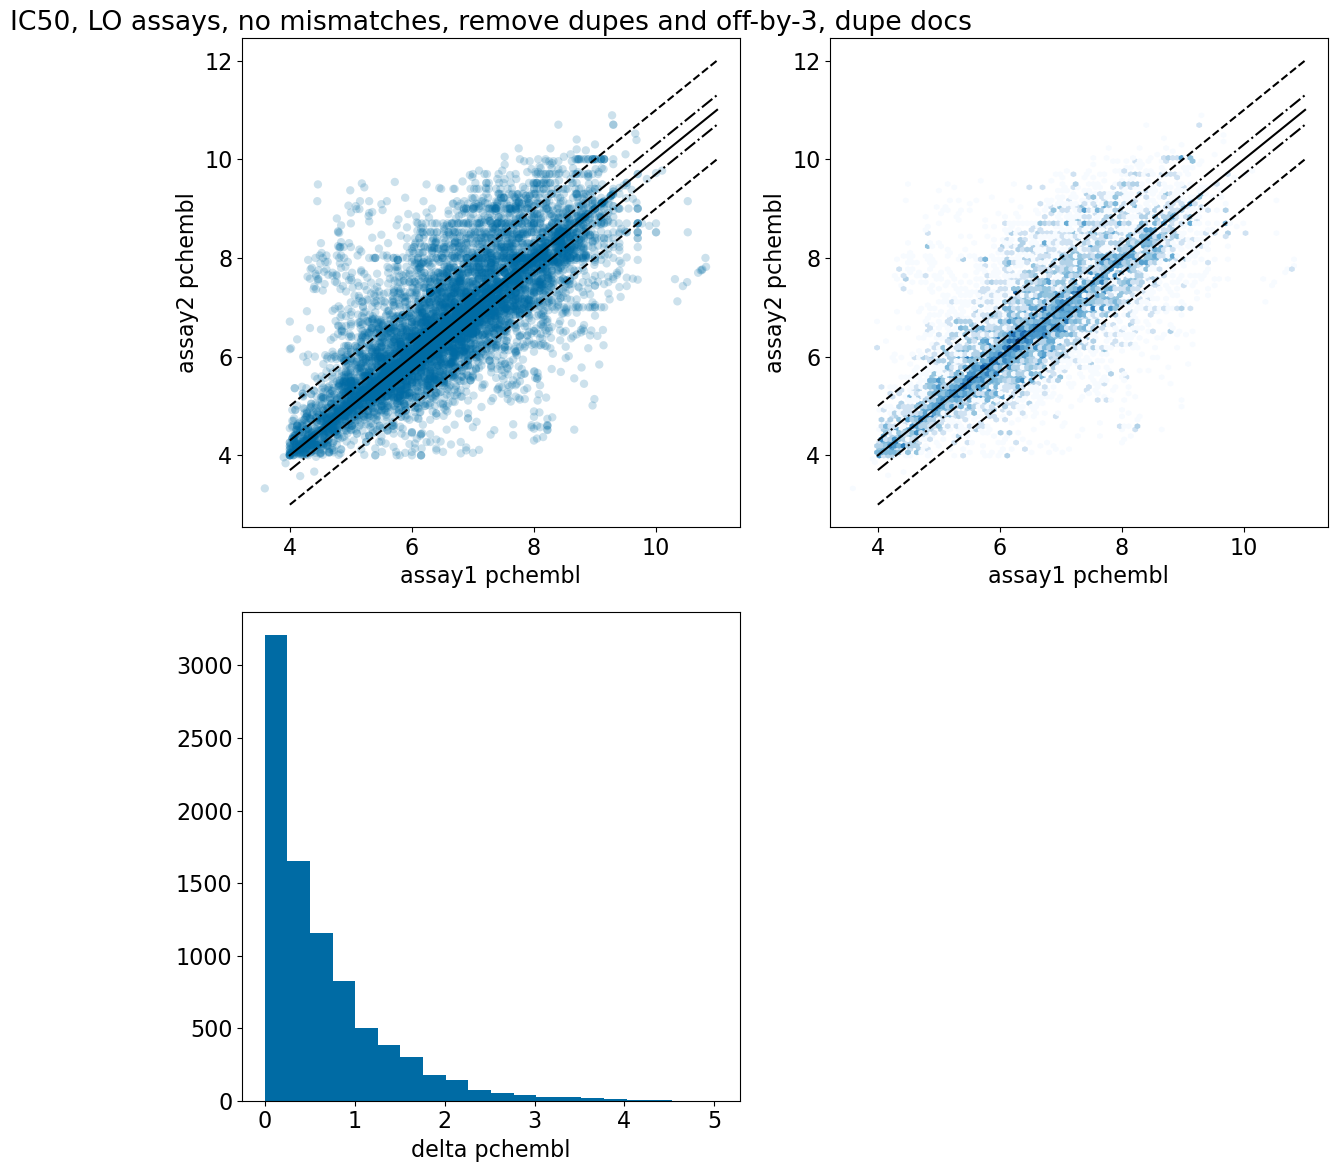

In [230]:
show_comparison(pts[tag],tag)

In [235]:
tag = 'Ki, LO assays, no mismatches, remove dupes and off-by-3, dupe docs'
pts[tag] = gather_data('Ki',noDuplicateDocs=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 120 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

R2=0.58, Spearman R=0.79 MAE=0.12
3343 points. Fraction > 0.3: 0.41, fraction > 1.0: 0.17
Fraction with different classifications:
	 bin=5: 0.05, kappa=0.70, balanced=0.85
	 [[2989, 71], [80, 203]]
	 bin=6: 0.08, kappa=0.74, balanced=0.87
	 [[2532, 141], [138, 532]]
	 bin=7: 0.15, kappa=0.70, balanced=0.85
	 [[1642, 256], [243, 1202]]
	 bin=8: 0.12, kappa=0.63, balanced=0.84
	 [[507, 132], [282, 2422]]
	 bin=9: 0.05, kappa=0.49, balanced=0.86
	 [[100, 29], [158, 3056]]


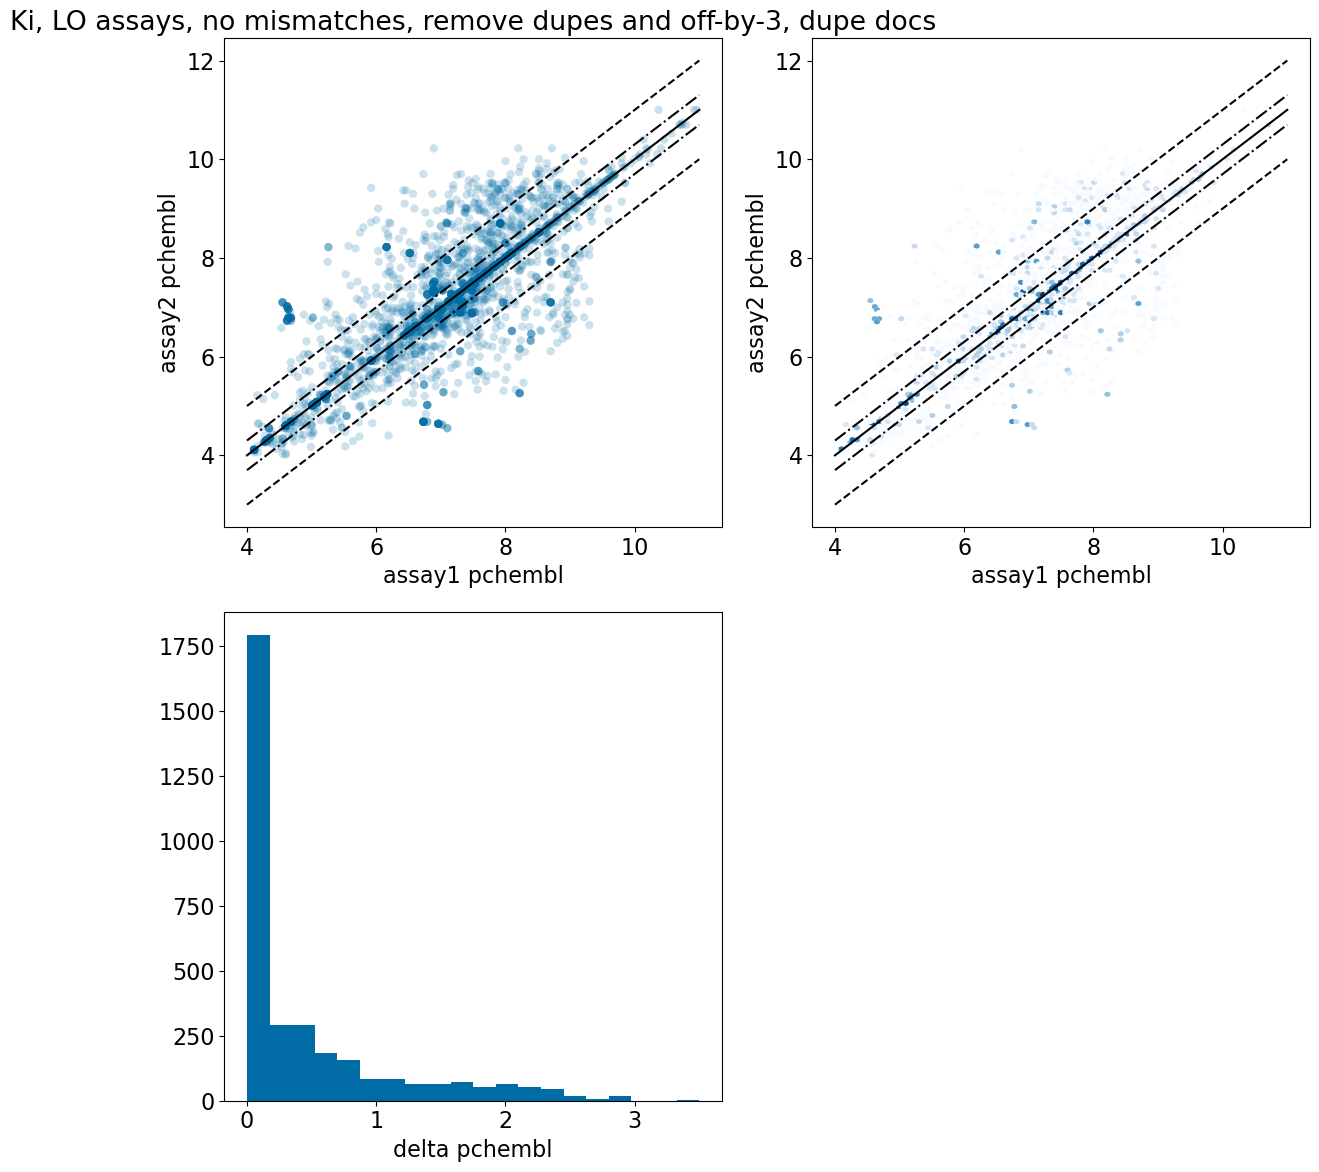

In [236]:
show_comparison(pts[tag],tag)

In [237]:
pts['xC50, no mismatches, remove dupes and off-by-3'] = gather_data('xC50',maxAssaySize=10000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 48 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

R2=0.76, Spearman R=0.91 MAE=0.01
1164 points. Fraction > 0.3: 0.25, fraction > 1.0: 0.08
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.83, balanced=0.91
	 [[1086, 10], [12, 56]]
	 bin=6: 0.04, kappa=0.88, balanced=0.95
	 [[866, 30], [20, 248]]
	 bin=7: 0.07, kappa=0.85, balanced=0.92
	 [[436, 41], [46, 641]]
	 bin=8: 0.07, kappa=0.69, balanced=0.86
	 [[107, 33], [47, 977]]
	 bin=9: 0.02, kappa=0.65, balanced=0.85
	 [[27, 11], [17, 1109]]


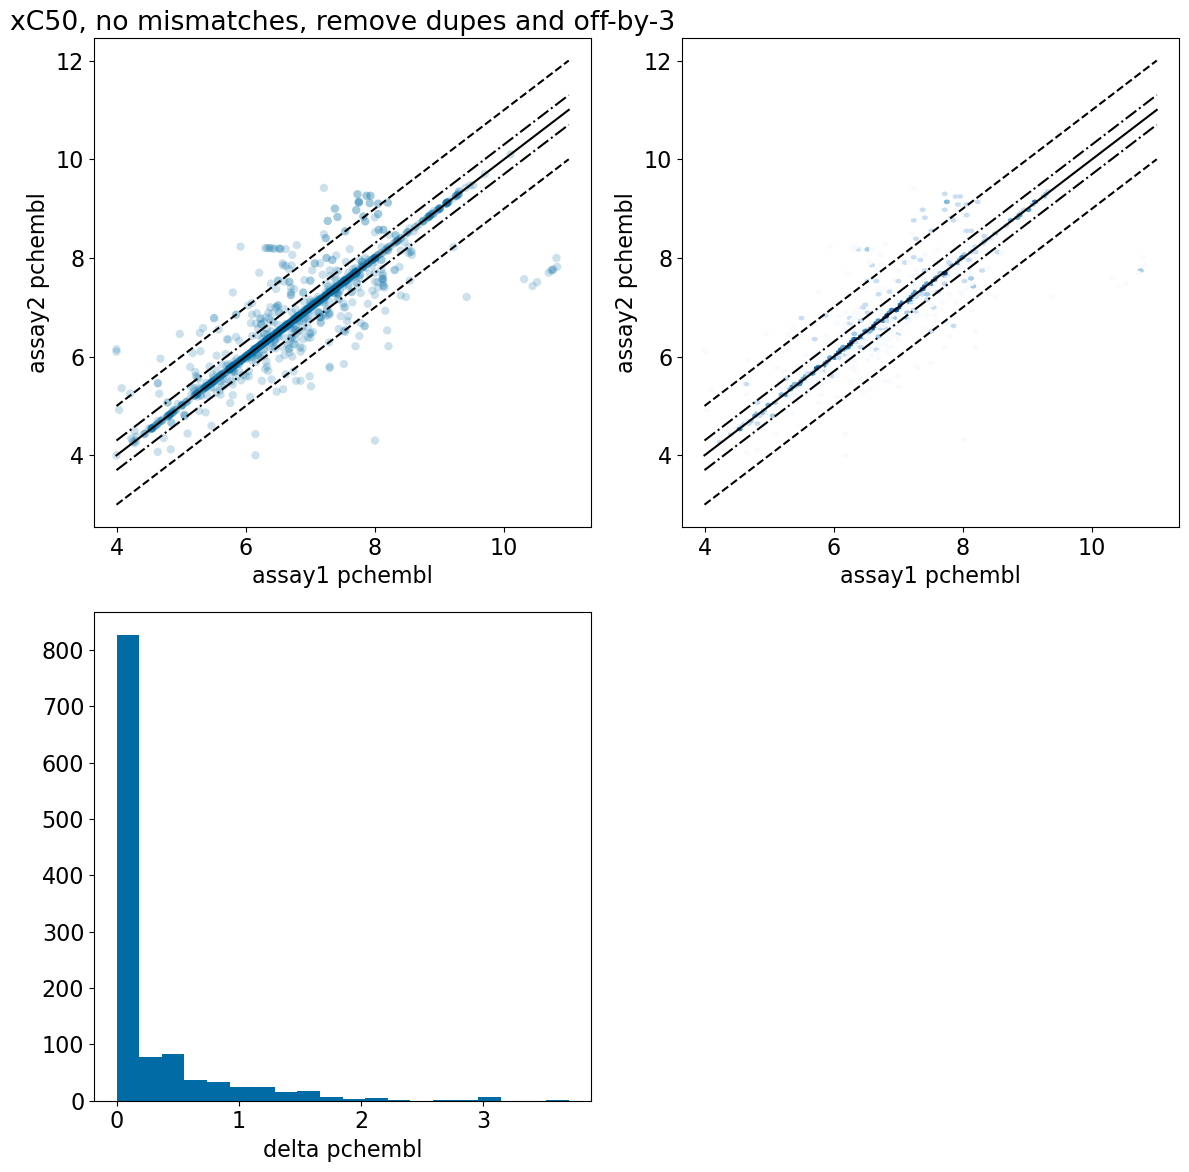

In [238]:
opt = 'xC50, no mismatches, remove dupes and off-by-3'
show_comparison(pts[opt],opt)

In [239]:
pts['xC50, only assay_type, remove dupes and off-by-3'] = gather_data('xC50',maxMatch=False,maxAssaySize=10000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 225 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

R2=0.72, Spearman R=0.87 MAE=0.03
4771 points. Fraction > 0.3: 0.31, fraction > 1.0: 0.12
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.80, balanced=0.90
	 [[4437, 54], [52, 228]]
	 bin=6: 0.06, kappa=0.83, balanced=0.92
	 [[3563, 172], [114, 922]]
	 bin=7: 0.09, kappa=0.80, balanced=0.90
	 [[2018, 264], [221, 2268]]
	 bin=8: 0.09, kappa=0.67, balanced=0.84
	 [[618, 221], [236, 3696]]
	 bin=9: 0.03, kappa=0.54, balanced=0.76
	 [[94, 84], [67, 4526]]


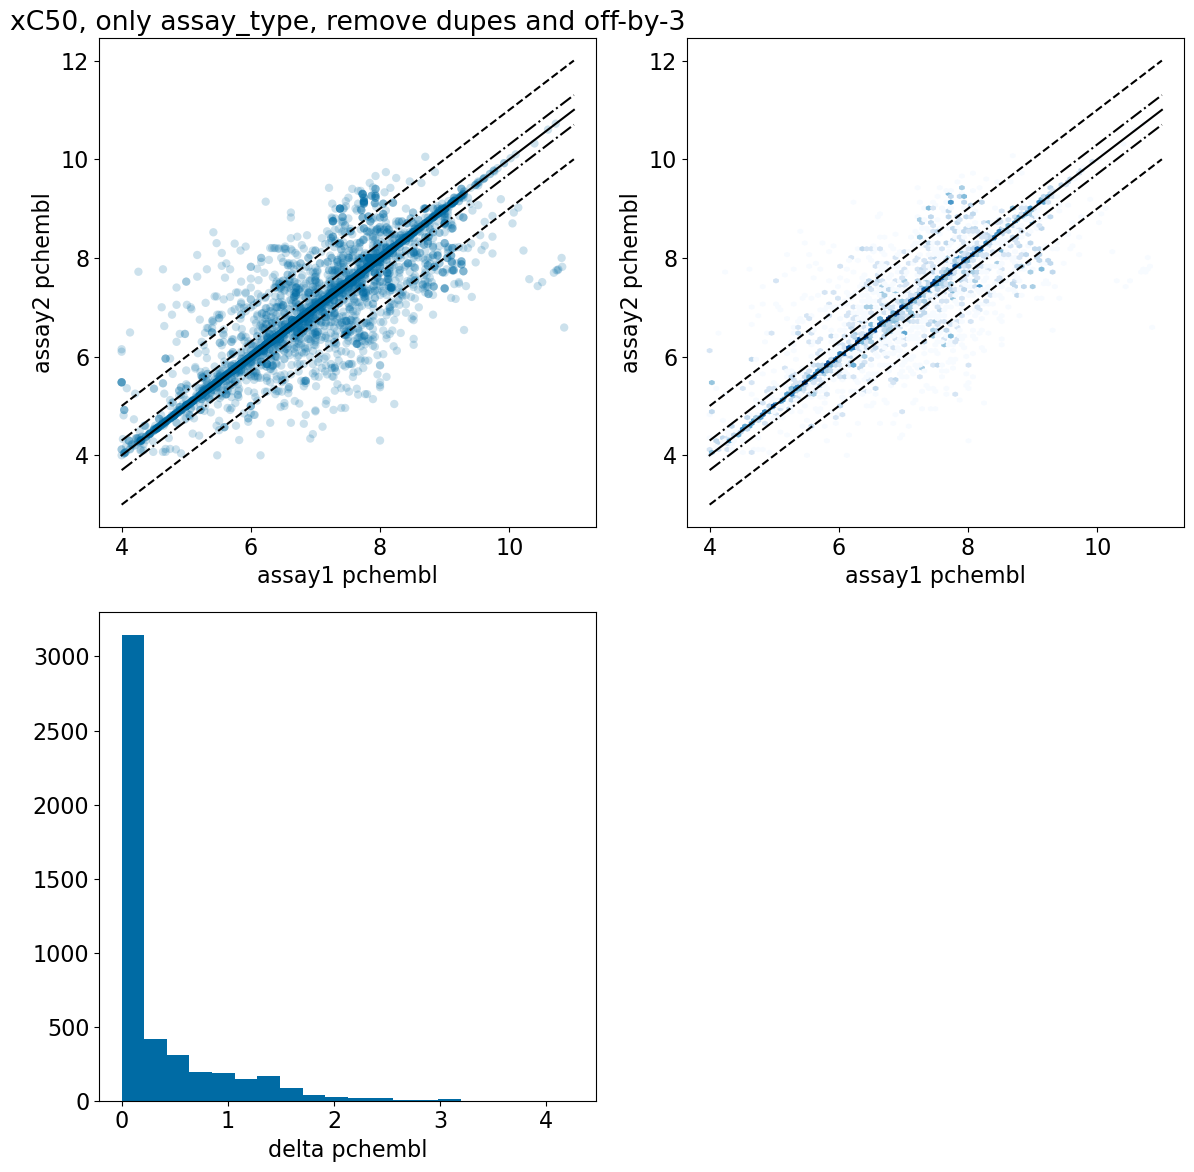

In [240]:
opt ='xC50, only assay_type, remove dupes and off-by-3'
show_comparison(pts[opt],opt)

# More

In [115]:
pts['IC50, only assay_type, remove dupes and off-by-3'] = gather_data('IC50',maxMatch=False,maxAssaySize=10000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 758 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

R2=0.34, Spearman R=0.67 MAE=0.50
26205 points. Fraction > 0.3: 0.63, fraction > 1.0: 0.28
Fraction with different classifications:
	 bin=5: 0.04, kappa=0.59, balanced=0.77
	 [[23970, 433], [800, 1002]]
	 bin=6: 0.16, kappa=0.55, balanced=0.75
	 [[17973, 1184], [3059, 3989]]
	 bin=7: 0.24, kappa=0.51, balanced=0.76
	 [[9427, 1786], [4735, 10257]]
	 bin=8: 0.17, kappa=0.46, balanced=0.78
	 [[3136, 1279], [3428, 18362]]
	 bin=9: 0.05, kappa=0.49, balanced=0.78
	 [[718, 490], [831, 24166]]


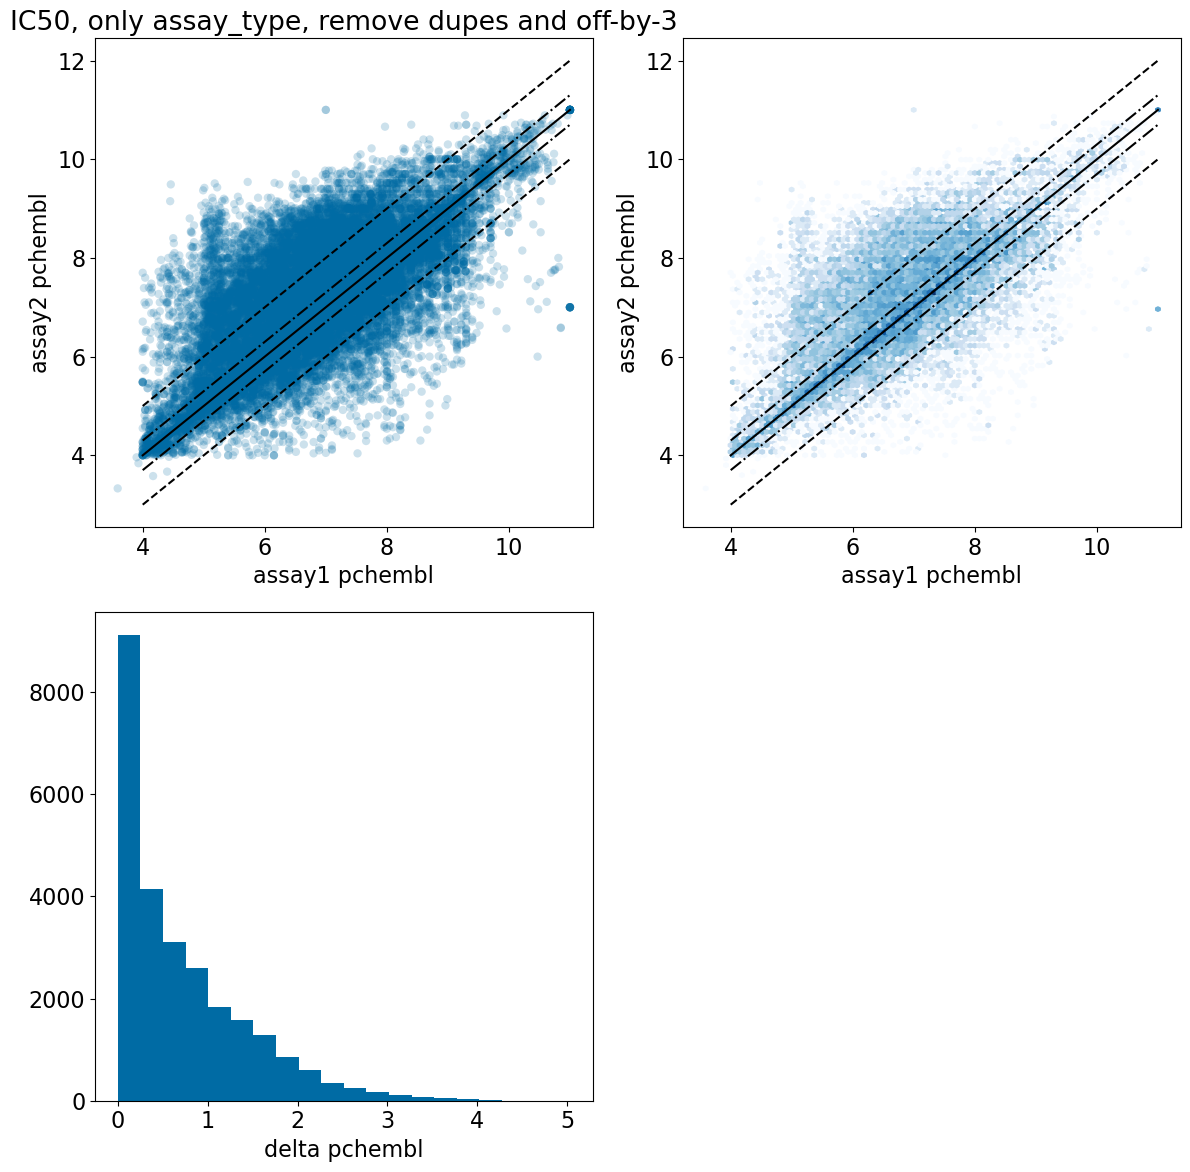

In [116]:
opt ='IC50, only assay_type, remove dupes and off-by-3'
show_comparison(pts[opt],opt)

In [119]:
pts['Ki, LO assays, no mismatches, no dupe removal'] = gather_data('Ki',includeActivityCuration=False)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 600 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


R2=0.82, Spearman R=0.91 MAE=0.00
9487 points. Fraction > 0.3: 0.17, fraction > 1.0: 0.07
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.86, balanced=0.92
	 [[8581, 91], [114, 701]]
	 bin=6: 0.03, kappa=0.88, balanced=0.94
	 [[7506, 160], [178, 1643]]
	 bin=7: 0.07, kappa=0.86, balanced=0.93
	 [[5345, 344], [288, 3510]]
	 bin=8: 0.05, kappa=0.85, balanced=0.94
	 [[1716, 141], [336, 7294]]
	 bin=9: 0.02, kappa=0.74, balanced=0.94
	 [[300, 36], [166, 8985]]


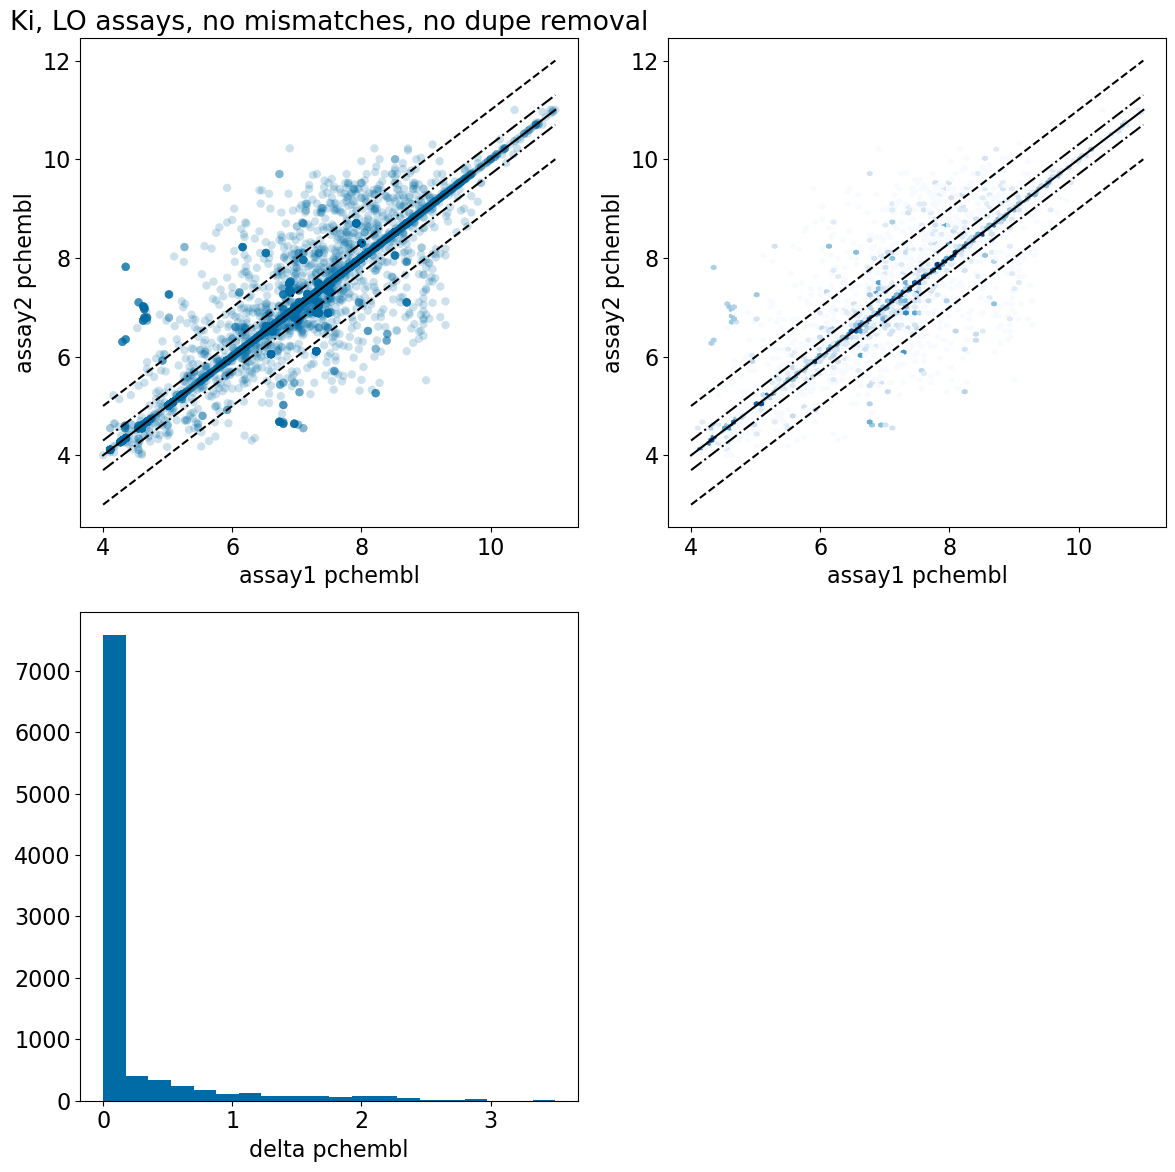

In [120]:
opt = 'Ki, LO assays, no mismatches, no dupe removal'
show_comparison(pts[opt],opt)

## Look at larger overlap values

In [137]:
tag = 'large overlap, IC50, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('IC50',minOverlap=20)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 210 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


In [138]:
show_comparison(pts[tag],tag)

R2=0.52, Spearman R=0.79 MAE=0.40
7217 points. Fraction > 0.3: 0.60, fraction > 1.0: 0.19
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.65, balanced=0.81
	 [[6143, 218], [292, 564]]
	 bin=6: 0.14, kappa=0.66, balanced=0.83
	 [[4299, 501], [592, 1825]]
	 bin=7: 0.17, kappa=0.62, balanced=0.81
	 [[2119, 542], [769, 3787]]
	 bin=8: 0.13, kappa=0.52, balanced=0.78
	 [[719, 356], [609, 5533]]
	 bin=9: 0.04, kappa=0.20, balanced=0.67
	 [[47, 78], [257, 6835]]


In [139]:
tag = 'large overlap, Ki, LO assays, no mismatches, remove dupes and off-by-3'
pts[tag] = gather_data('Ki',minOverlap=20)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 42 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

R2=0.28, Spearman R=0.70 MAE=0.51
1176 points. Fraction > 0.3: 0.68, fraction > 1.0: 0.27
Fraction with different classifications:
	 bin=5: 0.03, kappa=0.59, balanced=0.79
	 [[1114, 17], [18, 27]]
	 bin=6: 0.10, kappa=0.60, balanced=0.80
	 [[917, 61], [68, 130]]
	 bin=7: 0.19, kappa=0.59, balanced=0.80
	 [[555, 123], [113, 385]]
	 bin=8: 0.23, kappa=0.45, balanced=0.75
	 [[204, 81], [189, 702]]
	 bin=9: 0.14, kappa=0.17, balanced=0.69
	 [[24, 24], [144, 984]]


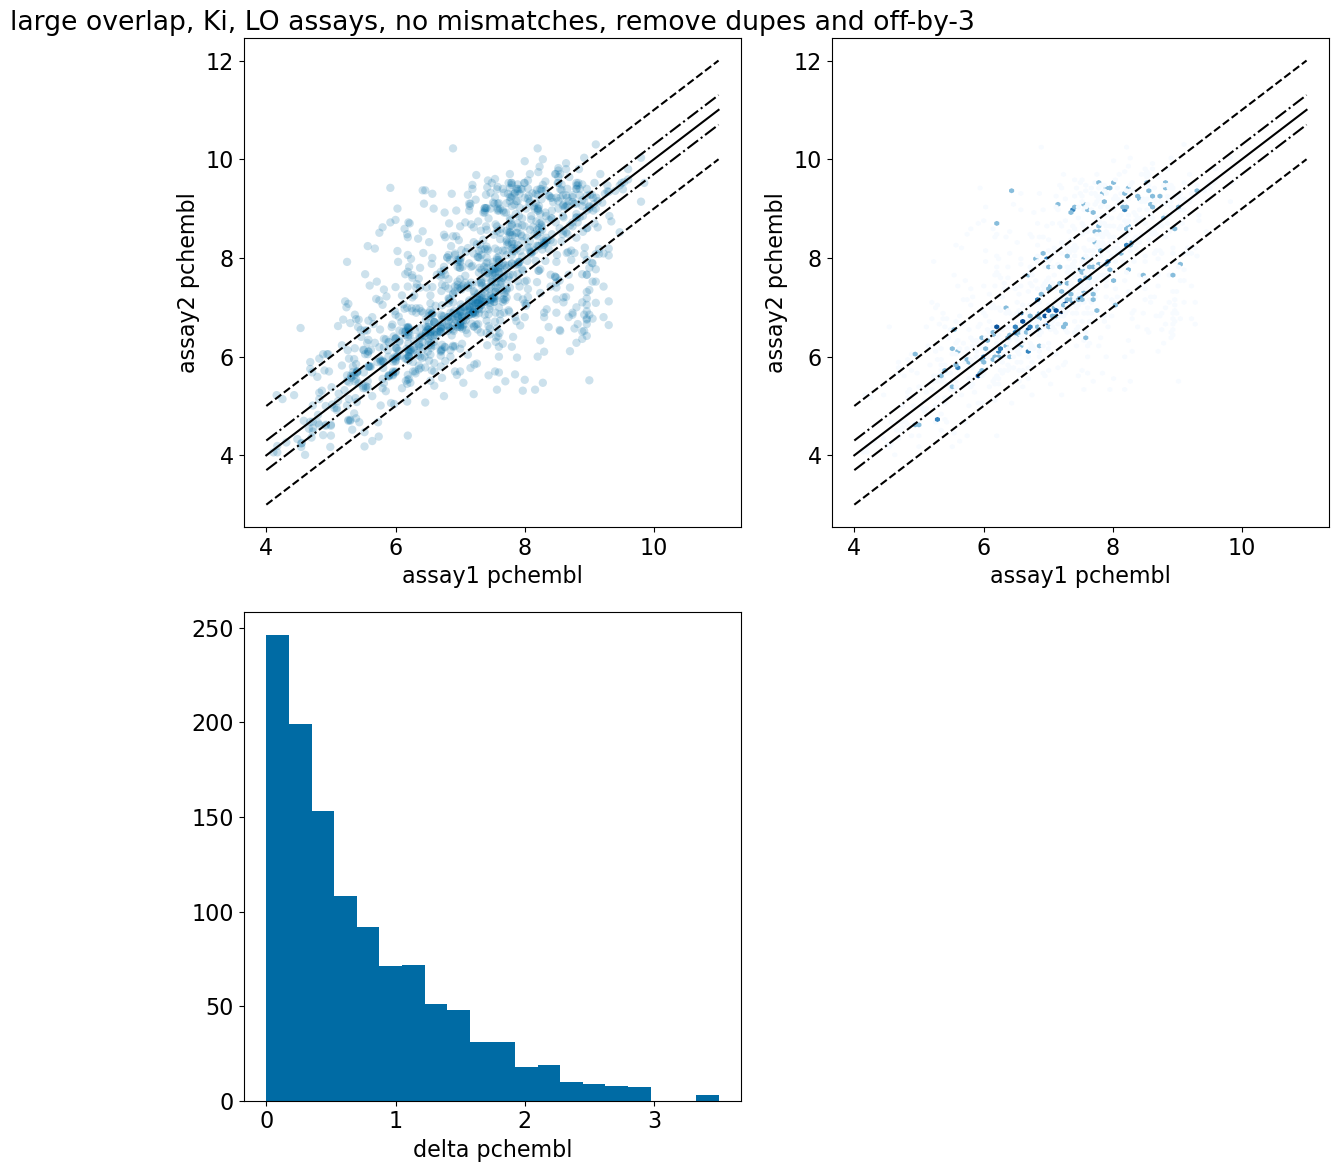

In [140]:
show_comparison(pts[tag],tag)

In [141]:
pts[tag][0]

[547294, Decimal('7.80'), Decimal('9.05'), 62885, 62884]

In [ ]:
def show_comparison(pts,titl):
    plt.figure(figsize=(12, 12))
    xp = np.array([x[1] for x in pts])
    yp = np.array([x[2] for x in pts])

    plt.subplot(2, 2, 1)
    plt.scatter(xp, yp, alpha=0.2, edgecolors='none')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')
    plt.title(titl)

    plt.subplot(2, 2, 2)
    plt.hexbin(xp, yp, cmap='Blues', bins='log')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')

    plt.subplot(2, 2, 3)
    delts = np.abs(xp - yp)
    plt.hist(delts, bins=20)
    plt.xlabel('delta pchembl')

    plt.tight_layout()

    r, p = stats.spearmanr(xp, yp)
    r2 = r2_score(xp, yp)
    print(
        f'R2={r2:.2f}, Spearman R={r:.2f} MAE={median_absolute_error(xp,yp):.2f}')

    npts = len(delts)
    frac1 = sum(delts > 0.3) / npts
    frac2 = sum(delts > 1) / npts
    print(
        f'{npts} points. Fraction > 0.3: {frac1:.2f}, fraction > 1.0: {frac2:.2f}')

    bins = [5, 6, 7, 8, 9]
    print(f'Fraction with different classifications:')
    for b in bins:
        x_class = xp > b
        y_class = yp > b
        confusion = [[sum(x_class & y_class),
                      sum(x_class & ~y_class)],
                     [sum(~x_class & y_class),
                      sum(~x_class & ~y_class)]]
        missed = sum((xp - b) * (yp - b) < 0) / npts
        print(
            f'\t bin={b}: {missed:.2f}, kappa={cohen_kappa_score(x_class,y_class):.2f}, balanced={balanced_accuracy_score(x_class,y_class):.2f}'
        )
        print(f'\t {confusion}')    